# Decision Tree Classifier

<p>
Decision trees are one of the most popular machine learning algorithms and are widely used in problems regarding classifications and regression. It is known for it's simplicity compared to most other machine algorithms as it mimics approximately a decision making of humans.
</p> 

We will go through cell by cell to understand the working of the algorithm before actually executing and witnessing the results in the form of accuracy and plots. 

## Implementation Details

### Preprocessing

1. Given a training data (csv file), we must break it into a training and validation files (approx. 80% training set).

2. The training data is used prepare a model which generalises (and not overfits) the data so as to use the fitted model to predict outcomes for unseen data 

### Decision Tree Algorithm

1. There are two  differnt types of data we must handle separately. One is the <b>Categorical</b> data and the other is the <b>Numeric</b> data. The Categorical data is dealt by generating differnt branches for every unique values in the attribute since they are small in number unlike the categorical data where the data could be in real numbered format where number of branches could be really huge. So we handle categorical values differently, which will be discussed in following points.<br><br>

2. In order to build a decision tree, we must decide attribute must be first decided in such a way that it generalizes the data split as purely as possible. For this we have something known as Impurity Measure. There are three main classes of impurity measure namely Entropy, Gini Index and Misclassification Error. The formula and implementaion will be discussed in the coming cells.<br><br>

3. Splitting categorical data is pretty straight forward as they are discrete and easily be classified. But continuous variables (numeric data) must undergo different processing. Consider a seet of real numbers 0.1,0,2,0.25,0.26,0.27,0.34... and so on. We first count the number of distinct variables (binary in our case) in our target attribute. Next, we sort the column in question and scan it row by row and use the knowledge of the count of binary variables to calculate impurity. At every scan, at that particular index we consider that to be a split point i.e we make a binary split of the attribute at every point. Next we calculate the gain we get from all such splits possibles. Examples of splits are <=0.2 and >0.2 or <=0.26 and >0.26 and so on.<br><br>

4. This way we keep a track these impurities (and thus gain) of every attribute. In the end we choose the attribute with most Information Gain or the least impurity measure (uncertainity). We repeat this process until we reach a pure state where the binary variables (target values) are divided in two seperate groups or if there's no more splits that can be done in the attribute (when all values are the same in one of the branches). <br><br>

5. Once a tree model is built, we take our test data to traverse through out tree model and evaluate the results into True Positive, True Negative, False Positive and False Negative which is used to calculate various measures like Accuracy, Precision, Recall and F-Score.


We discuss each step in the above mentioned algorithm with the help of the code in each cells.

Execute the next cell to import important packages.

In [6]:
import pandas as pd
import numpy as np
from numpy import log2 as log
import matplotlib.pyplot as plt
import math
import pprint

To import the csv file, please give your path in the variable <b>data</b> below before executing. Note, that you can also change the size of the Training-Validation data in the variable <b>num_of_rows</b>

In [7]:
'''
Preprocessing data.

Load the csv file into pandas dataframe
'''

def GetData(target_attribute):
    #~/Documents/SMAI/Assignment1/SamplePlayData.csv
    #~/Documents/SMAI/Assignment1/decision_Tree/train.csv
    data = pd.read_csv('~/Documents/SMAI/Assignment1/decision_Tree/train.csv')
    dataframe = pd.DataFrame(data)
    
    num_of_rows = math.floor(len(dataframe[target_attribute]) * 0.8)
    dataframe = dataframe.sample(frac=1).reset_index(drop=True)
    df = dataframe.copy()
    dataframe = dataframe.head(num_of_rows)  #Train
    test_data = df.tail(len(df[target_attribute]) - num_of_rows) #Test
    #test_data = dataframe.sample(frac=0.2)
    #actual_y = test_data[target_attribute].values
    #test_data = test_data.drop(target_attribute, 1)
    #train_data.sort() # sorts data
    #test_data.sort()
   
    columns = list(dataframe.columns)
    columns.remove(target_attribute)
    return dataframe,test_data,columns

The variable <b>target_variable</b> contains the name of the <b>target attribute</b> from your respective csv file.
The variable <b>catcolumns</b> consists of all the columns that consists of categorical columns and the variable <b>numcolumns</b> consists of all the numerical columns. This cell also calls the GetData() functions to get the details from the csv file

In [8]:
#Global initializations
target_attribute = 'left'
dataframe,test_data,columns = GetData(target_attribute)
catcolumns = ['sales','salary','promotion_last_5years','Work_accident']
numcolumns = ['satisfaction_level','last_evaluation','number_project','average_montly_hours','time_spend_company']

## Different ways of calculating impurities

As discussed in the algorithm above we must have a parameter through which we can split our data set in such a way that reduces the uncertainity of the split as much as possible (thus maximizing our chances of making our split as pure as possible).

### Misclassifiction Error

$M(p) = min(p,1-p)$

where p is the probability of the existance of binary variables (target) in the current attribute values.

In [9]:
def MissClassFormula(prob):
    return min(prob,1-prob)

In [10]:
def MissClass(dataframe,target_attribute):
    unique = list(dataframe[target_attribute].unique())
    return (MissClassFormula(len(dataframe[target_attribute][dataframe[target_attribute] == unique[0]])/len(dataframe[target_attribute])))

### Gini Index

$G(p) = 2 * p * (1-p)$

where p is the probability of the existance of binary variables (target) in the current attribute values.

In [11]:
'''
used by GiniAttr and Gini functions
'''
def GiniFormula(prob):
    if prob == 0:
        return 0
    G = 2 * prob * (1-prob)
    return G

In [12]:
def Gini(dataframe,target_attribute):
    unique = list(dataframe[target_attribute].unique())
    return (GiniFormula(len(dataframe[target_attribute][dataframe[target_attribute] == unique[0]])/len(dataframe[target_attribute])))

### Entropy

$E(p) = -1 * (p * log_2 p + (1-p) * log_2 (1-p))$

where p is the probability of the existance of binary variables (target) in the current attribute values.

In [13]:
'''
This function is common to Entropy and InformationGain 
'''
def EntropyFormula(prob):
    if prob == 0 or prob == 1:
        return 0
    E = prob * np.log2(prob) + (1-prob) * np.log2(1-prob)
    E = -1 * E
    return E

In [14]:
def Entropy(dataframe,column):
    unique_values = dataframe[column].unique()
    E = 0
    col_len = len(dataframe[column])
    prob = (dataframe[column].value_counts()[unique_values[0]])/col_len
    E = EntropyFormula(prob)
    return E

### Information Gain

Information Gain can be understood as how low the uncertaininty of a split of atttribute values is with respect to the target values. Thus we aim for low uncertainity i.e high Information Gain.

$Gain(S,A) = H(S) - \sum_{V \in A}\dfrac{|V|}{|A|}E(S_V)$

where $H(S)$ is the entropy of the target attribute which can be calculated through any of the three impurities above i.e $E(p),G(p)$ or $M(p)$,<br>
A is the attribute in question,<br>
V is the possible value of A,<br>
$E(S_V)$ is the entropy of the subset of the attribute A with respect to the target attribute S.

In [15]:
'''
Works like  Information Gain
'''
def Gain(dataframe,attribute,target_attribute,GI,impurity):
    target_variables = list(dataframe[target_attribute].unique())
    unique_values = dataframe[attribute].unique()
    G=0
    for attr in unique_values:
        prob = (len(dataframe[attribute][dataframe[attribute] == attr][dataframe[target_attribute] == target_variables[0]]))/len(dataframe[attribute][dataframe[attribute]==attr])
        if impurity == 'gini':
            uncertainity = GiniFormula(prob)
        elif impurity == 'entropy':
            uncertainity = EntropyFormula(prob)
        elif impurity == 'missclass':
            uncertainity = MissClassFormula(prob)
        G += (len(dataframe[attribute][dataframe[attribute] == attr])/len(dataframe[attribute]))*uncertainity
    return GI-G

### Continous to Categorical

The logic here is to perform a binary split on every possible (unique) values of an attribute $A$ and calculate it's Information Gain with respect to the target variable. The split with the maximum Gain will be chosen as the point of split. To make it clearer consider a value $s$ in the attribute $A$ which gives the maximum gain. Then this continous attribute is now divided into two categories ${D_{<=s}}$ and $D_{>s}$.

The function <b>discretize()</b> does this job. <br>
The function <b>discrete_IG()</b> calculates the entropy of the attribute $A$ using one of the three impurities.


In [16]:
def discrete_IG(split1,attribute_length,split_size,impurity):
    prob1 = split1/split_size
    if impurity == 'entropy':
        E = EntropyFormula(prob1)
    elif impurity == 'gini':
        E = GiniFormula(prob1)
    elif impurity == 'missclass':
        E = MissClassFormula(prob1)
    I = split_size/attribute_length
    WE = I * E #weighted entropy
    return WE

In [17]:
def discretize(impurity,dataframe,attribute,target_attribute,target_values,ET):
    
    df_u = np.unique(dataframe[attribute]).shape[0]
    #print("[printing 1 ]",df_u)
    if df_u <= 1:
        return (0,-2) 
    #print("[discrte] dataframe-->attribute",attribute,dataframe)    
    dataframe = dataframe.sort_values(by=[attribute])
    df_attr_arr = dataframe[attribute].values
    #print("[discrte] dataframe-->attribute",attribute,dataframe)
    listofIG = []
    attribute_length = len(dataframe[attribute])
    start_index = 0
    WE_head,WE_tail,gain,split,high = 0,0,-5,-1,-3
    #print("[discretize] dataframe[target_attribute].value_counts()-->",dataframe[target_attribute].value_counts())
    V1 = len(dataframe[target_attribute][dataframe[target_attribute] == target_values[0]])
    V2 = attribute_length - V1
    split1_V1,split1_V2=0,0
    split2_V1,split2_V2=V1,V2
    #print("[discretize] dataframe[attribute]-->",dataframe[target_attribute])
    df_array = dataframe[target_attribute].values
    #print("[discrete] ET = ",ET)
    #print("[discrete] V1 = ",V1," V2 = ",V2)
    while start_index < (attribute_length-1):
        if df_array[start_index] == target_values[0]:
            split1_V1+=1
            split2_V1-=1
        else:
            split1_V2+=1
            split2_V2-=1
        if df_attr_arr[start_index] != df_attr_arr[start_index+1]:
            #print("[discrete] attr -->",df_attr_arr[start_index])
            tail_value = attribute_length - (start_index + 1)
            WE_head = discrete_IG(split1_V1,attribute_length,start_index+1,impurity)
            WE_tail = discrete_IG(split2_V1,attribute_length,tail_value,impurity)
            gain = ET - (WE_head+WE_tail)
            #print(gain)
            listofIG.append(gain)
            if gain > high:
                high = gain
                split = df_attr_arr[start_index] 
            
        start_index+=1
            
    return high,split

### Choosing the best feature

This function chooses the best feature (attribute) on which conditions will be made to build the tree. <br>
The best feature is found by calculating the Information Gain of various attributes and selecting the attribute with most gain.

In [18]:
'''
Calculates Gain Ratio and returns the best attribute
DOUBT: What happens when Intrinsic value is 0?
'''
def WinnerAttr(impurity,dataframe,target_attribute,target_values,ET,attributes,catcolumns=None,numcolumns=None):
    GainRatio = []
    splitArray=[]
    split = -1
    flag = 0
    
    for attribute in attributes:
        if numcolumns != None and attribute in numcolumns:
            #print("[WinnerEntropy] Visited numeric column -- >",attribute)
            IG,split = discretize(impurity,dataframe,attribute,target_attribute,target_values,ET)
            #print("[WinnerEntropy] Visited numeric column -- >",attribute," Split -->",split," IG-->",IG)
        else: 
            split = -1
            #print("[WinnerEntropy] Visited categoric column -- >",attribute)
            IG = Gain(dataframe,attribute,target_attribute,ET,impurity)
            
        GainRatio.append(IG) #divide by Intr for intrinsic
        splitArray.append(split)
    if len(set(GainRatio)) == 1 and (numcolumns is not None):   #Remove this or change logic later because only cat doesn't work 
        #print("HI")
        flag = 1
    return attributes[np.argmax(GainRatio)],splitArray[np.argmax(GainRatio)],flag

### Building the Decision Tree

This is a recursive function which traverses till a leaf node is found. The leaf node will be our final answer to a query.

The steps followed by this tree is mentioned in the Implementation Details at the very beginning.


In [19]:
def BuildTree(depth,impurity,dataframe,target_attribute,target_values,ET,columns,catcolumns=None,numcolumns=None,Tree=None):
    global num_nodes
    num_nodes+=1
    
    if len(columns) == 0 or (depth is not None and depth == 0):
        prob=0
        a = len(dataframe[target_attribute][dataframe[target_attribute] == target_values[0]])
        b = len(dataframe[target_attribute][dataframe[target_attribute] == target_values[1]])
        if a>=b:
            return target_values[0]
        else:
            return target_values[1]
  
    if impurity == 'entropy':    
        ET = Entropy(dataframe,target_attribute)
    elif impurity == 'gini':
        ET = Gini(dataframe,target_attribute)
    elif impurity == 'missclass':
        ET = MissClass(dataframe,target_attribute)
    Node,split,flag = WinnerAttr(impurity,dataframe,target_attribute,target_values,ET,columns,catcolumns,numcolumns) 
    if depth is not None:
        depth-=1
    
    if flag== 1 or len(dataframe[Node].unique()) == 1:
        prob=0
        a = len(dataframe[target_attribute][dataframe[target_attribute] == target_values[0]])
        b = len(dataframe[target_attribute][dataframe[target_attribute] == target_values[1]])
        if a>=b:
            return target_values[0]
        else:
            return target_values[1] 

    if Tree == None:
        Tree = {}
        Tree[Node] = {}
    if split == -1:    
        unique_values = list(dataframe[Node].unique())
    else:
        unique_values = []
        unique_values.append(split)
        unique_values.append(split+1)
    for value in unique_values:
        newcol = columns.copy()
        if len(dataframe[target_attribute].unique())== 1:
            return (list(dataframe[target_attribute].unique())[0]) 
        else:
            
            Tree[Node][value] = {}
            if split == -1:
                newcol.remove(Node)
                Tree[Node][value]=BuildTree(depth,impurity,dataframe[dataframe[Node] == value], \
                    target_attribute,target_values,ET,newcol,catcolumns,numcolumns)
            else:
                if value == unique_values[0]:
                    Tree[Node][value] = BuildTree(depth,impurity,dataframe[dataframe[Node] <= split],target_attribute, \
                                target_values,ET,newcol,catcolumns,numcolumns)
                else:
                    Tree[Node][value] = BuildTree(depth,impurity,dataframe[dataframe[Node] > split], \
                                target_attribute,target_values,ET,newcol,catcolumns,numcolumns)               
    return Tree

### Prediction using test data

The function <b>Measure(Model,TestData,**Args)</b> is the function that <b>predicts</b> the value for a test set. <br>*Args --> consists of <b>numcolumns</b> which is an array of numerical columns and <b>target_attribute</b> is the name of the target attribute 

In [20]:
def predict(TreeModel,test_data,row,numcolumns):
    while isinstance(TreeModel,dict):
        attribute = next(iter(TreeModel))
        #print("attribute-->",attribute)
        value = test_data[attribute].values[row]
        #print("value -->",value)
        try:
            if attribute not in numcolumns:
                #print(TreeModel[attribute])
                TreeModel = TreeModel[attribute][value]
            else:
                if value <= next(iter(TreeModel[attribute])):
                    TreeModel = TreeModel[attribute][next(iter(TreeModel[attribute]))]
                else:
                    TreeModel = TreeModel[attribute][next(iter(TreeModel[attribute])) + 1]
        except KeyError:
            return 0
    return TreeModel

In [21]:
def predictY(TreeModel,test_data,numcolumns,target_attribute):
    predicted_y = []
    size = len(test_data[target_attribute])
    #print(size)
    i = 0
    while i<= size-1:
        #print("[predicted_y] i -->",i)
        y = predict(TreeModel,test_data,i,numcolumns)
        #print(y)
        predicted_y.append(y)
        i+=1
    return predicted_y 

In [22]:
def Measure(TreeModel,test_data,numcolumns,target_attribute):
    '''
    Predict using Tree Model
    '''
    #global actual_y
    actual_y = test_data[target_attribute].values
    predicted_y = predictY(TreeModel,test_data,numcolumns,target_attribute)
    #print(len(predicted_y))
    #print(len(actual_y))
    TP,TN,FP,FN = 0,0,0,0
    j=0
    for i in actual_y:
        if i == 1 and i == predicted_y[j]:
            TN+=1
        elif i == 1 and i!=predicted_y[j]:
            FP+=1
        elif i == 0 and i == predicted_y[j]:
            TP+=1
        elif i == 0 and i!=predicted_y[j]:
            FN+=1
        j+=1    


    Accuracy = ((TP+TN)/(TP+TN+FP+FN))
    Precision = (TP/(TP+FP))
    Recall = (TP/(TP+FN))
    FScore = 2/((1/Precision)+(1/Recall))
    
    
    return Accuracy,Precision,Recall,FScore
    

# Part-1

### Train decision tree only on categorical data. Report precision, recall, f1 score and accuracy.

In [192]:
'''
Q1. ENTROPY (Only categorical)
target_values -> Yes/No
'''
impurity = 'entropy'
target_values = dataframe[target_attribute].unique()
depth = None
num_nodes = 0
print("Preparing tree...")
TreeModel = BuildTree(depth,impurity,dataframe,target_attribute,target_values,None,catcolumns,None,None,None)
print("Tree Created")
print("\nEntropy (Only Categorical)")
print("=========================================")
Accuracy,Precision,Recall,FScore = Measure(TreeModel,test_data,numcolumns,target_attribute)
print("Accuracy : ",Accuracy)
print("Precision: ",Precision)
print("Recall   : ",Recall)
print("F-Score  : ",FScore)
print("=========================================")

Preparing tree...
Tree Created

Entropy (Only Categorical)
Accuracy :  0.7508896797153025
Precision:  0.7508896797153025
Recall   :  1.0
F-Score  :  0.8577235772357725


# Part-2
### Train the decision tree with categorical and numerical features. Report precision, recall, f1 score and accuracy.

In [23]:
'''
Q2. ENTROPY with Continuous and Categorical
'''
impurity = 'entropy'
depth = None
num_nodes = 0
target_values = dataframe[target_attribute].unique()
print("Preparing Tree...")
TreeModel = BuildTree(depth,impurity,dataframe,target_attribute,target_values,None,columns,None,numcolumns,None)
print("Tree created")
print("\nEntropy (Continuous and Categorical)")
print("=========================================")
Accuracy,Precision,Recall,FScore = Measure(TreeModel,test_data,numcolumns,target_attribute)
print("Accuracy : ",Accuracy)
print("Precision: ",Precision)
print("Recall   : ",Recall)
print("F-Score  : ",FScore)
print("=========================================")

Preparing Tree...
Tree created

Entropy (Continuous and Categorical)
Accuracy :  0.9706405693950177
Precision:  0.9888693614528412
Recall   :  0.9729106628242075
F-Score  :  0.9808251016850669


# Part-3
### Contrast the effectiveness of Misclassification rate, Gini, Entropy as impurity measures in terms of precision, recall and accuracy.

In [194]:
'''
Q1. ENTROPY (Only categorical)
target_values -> Yes/No
'''
impurity = 'entropy'
target_values = dataframe[target_attribute].unique()
depth = None
num_nodes = 0
print("Preparing tree...")
TreeModel = BuildTree(depth,impurity,dataframe,target_attribute,target_values,None,catcolumns,None,None,None)
print("Tree Created")
print("\nEntropy (Only categorical)")
print("=========================================")
Accuracy,Precision,Recall,FScore = Measure(TreeModel,test_data,numcolumns,target_attribute)
print("Accuracy : ",Accuracy)
print("Precision: ",Precision)
print("Recall   : ",Recall)
print("F-Score  : ",FScore)
print("=========================================")

Preparing tree...
Tree Created

Entropy (Only categorical)
Accuracy :  0.7508896797153025
Precision:  0.7508896797153025
Recall   :  1.0
F-Score  :  0.8577235772357725


In [195]:
'''
Q1. GINI (Only categorical)
'''
impurity = 'gini'
GI = Gini(dataframe,target_attribute)
depth = None
num_nodes = 0
print("Preparing tree...")
TreeModel = BuildTree(depth,impurity,dataframe,target_attribute,target_values,None,catcolumns,None,None,None)
print("Tree Created...")
print("\nGini (only categorical)")
print("=========================================")
Accuracy,Precision,Recall,FScore = Measure(TreeModel,test_data,numcolumns,target_attribute)
print("Accuracy : ",Accuracy)
print("Precision: ",Precision)
print("Recall   : ",Recall)
print("F-Score  : ",FScore)
print("=========================================")

Preparing tree...
Tree Created...

Gini (only categorical)
Accuracy :  0.7508896797153025
Precision:  0.7508896797153025
Recall   :  1.0
F-Score  :  0.8577235772357725


In [196]:
'''
Q1. Misclassification Error (Only categorical)
'''
impurity = 'missclass'
GI = Gini(dataframe,target_attribute)
depth = None
num_nodes = 0
print("Preparing tree...")
TreeModel = BuildTree(depth,impurity,dataframe,target_attribute,target_values,None,catcolumns,None,None,None)
print("Tree Created...")
print("\nMisclassification (Only categorical)")
print("=========================================")
Accuracy,Precision,Recall,FScore = Measure(TreeModel,test_data,numcolumns,target_attribute)
print("Accuracy : ",Accuracy)
print("Precision: ",Precision)
print("Recall   : ",Recall)
print("F-Score  : ",FScore)
print("=========================================")

Preparing tree...
Tree Created...

Misclassification (Only categorical)
Accuracy :  0.7513345195729537
Precision:  0.7512238540275924
Recall   :  1.0
F-Score  :  0.8579415501905973


In [200]:
'''
Q2. ENTROPY with Continuous and Categorical
'''
impurity = 'entropy'
depth = None
num_nodes = 0
target_values = dataframe[target_attribute].unique()
print("Preparing Tree...")
TreeModel = BuildTree(depth,impurity,dataframe,target_attribute,target_values,None,columns,None,numcolumns,None)
print("Tree created")
print("\nEntropy (Continuous and Categorical)")
print("=========================================")
Accuracy,Precision,Recall,FScore = Measure(TreeModel,test_data,numcolumns,target_attribute)
print("Accuracy : ",Accuracy)
print("Precision: ",Precision)
print("Recall   : ",Recall)
print("F-Score  : ",FScore)
print("=========================================")

Preparing Tree...
Tree created

Entropy (Continuous and Categorical)
Accuracy :  0.9706405693950177
Precision:  0.9897342995169082
Recall   :  0.9709715639810427
F-Score  :  0.980263157894737


In [198]:
'''
Q2. GINI with Continuous and Categorical
'''
impurity = 'gini'
depth = None
num_nodes = 0
target_values = dataframe[target_attribute].unique()
print("Preparing Tree...")
TreeModel = BuildTree(depth,impurity,dataframe,target_attribute,target_values,None,columns,None,numcolumns,None)
print("Tree created")
print("\nGini (Continuous and Categorical)")
print("=========================================")
Accuracy,Precision,Recall,FScore = Measure(TreeModel,test_data,numcolumns,target_attribute)
print("Accuracy : ",Accuracy)
print("Precision: ",Precision)
print("Recall   : ",Recall)
print("F-Score  : ",FScore)
print("=========================================")

Preparing Tree...
Tree created

Gini (Continuous and Categorical)
Accuracy :  0.9719750889679716
Precision:  0.9874025194961008
Recall   :  0.9751184834123223
F-Score  :  0.9812220566318927


In [199]:
'''
Q2. MISCLASSIFICATION with Continuous and Categorical
'''
impurity = 'missclass'
depth = None
num_nodes = 0
target_values = dataframe[target_attribute].unique()
print("Preparing Tree...")
TreeModel = BuildTree(depth,impurity,dataframe,target_attribute,target_values,None,columns,None,numcolumns,None)
print("Tree created")
print("\nMisclassification (Continuous and Categorical)")
print("=========================================")
Accuracy,Precision,Recall,FScore = Measure(TreeModel,test_data,numcolumns,target_attribute)
print("Accuracy : ",Accuracy)
print("Precision: ",Precision)
print("Recall   : ",Recall)
print("F-Score  : ",FScore)
print("=========================================")

Preparing Tree...
Tree created

Misclassification (Continuous and Categorical)
Accuracy :  0.9786476868327402
Precision:  0.9834905660377359
Recall   :  0.9881516587677726
F-Score  :  0.9858156028368795


# Part-4
### Visualise training data on a 2-dimensional plot taking one feature (attribute) on one axis and other feature on another axis. Take two suitable features to visualise decision tree boundary (Hint: use scatter plot with different colors for each label).

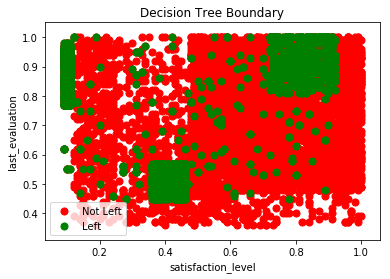

In [24]:
x = dataframe[list(dataframe.columns)[0]]
y = dataframe[list(dataframe.columns)[1]]
z = dataframe[target_attribute]

left = []
new_x = []
j = 0
for i in z:
    if i == 1:
        left.append(y[j])
        new_x.append(x[j])
    j+=1    
plt.scatter(x,y,color = 'r',label = 'Not Left',s=50)
plt.scatter(new_x,left,color = 'g',label = 'Left',s=50)
plt.xlabel(list(dataframe.columns)[0])
plt.ylabel(list(dataframe.columns)[1])
plt.title('Decision Tree Boundary')
plt.legend()
plt.show()

# Part-5
### Plot a graph of training and validation error with respect to depth of your decision tree. Also plot the training and validation error with respect to number of nodes in the decision tree.

Depth  1  measured
Depth  2  measured
Depth  3  measured
Depth  4  measured
Depth  5  measured
Depth  6  measured
Depth  7  measured
Depth  8  measured
Depth  9  measured
Depth  10  measured


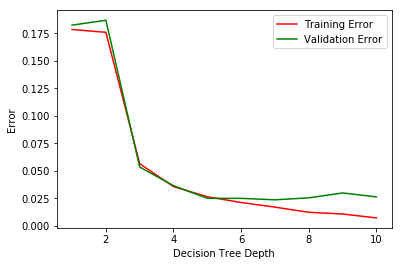

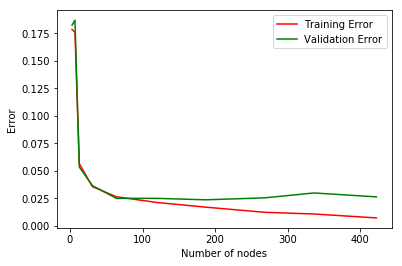

In [180]:
#Training Error
'''
Q2. ENTROPY with Continuous and Categorical
'''
impurity = 'entropy'
target_values = dataframe[target_attribute].unique()
depth = 1
depth_array = []
training_error = []
validation_error = []
nodes = []
while depth < 11:
    print("Depth ",depth," measured")
    num_nodes = 0
    TreeModel = BuildTree(depth,impurity,dataframe,target_attribute,target_values,None,columns,None,numcolumns,None)
    nodes.append(num_nodes)
    Accuracy,Precision,Recall,FScore = Measure(TreeModel,dataframe,numcolumns,target_attribute)
    training_error.append(1-Accuracy)
    Accuracy,Precision,Recall,FScore = Measure(TreeModel,test_data,numcolumns,target_attribute)
    validation_error.append(1-Accuracy)
    depth_array.append(depth)
    depth+=1
plt.plot(depth_array,training_error,color = 'r',label = 'Training Error')
plt.plot(depth_array,validation_error,color = 'g',label = 'Validation Error')
plt.xlabel('Decision Tree Depth')
plt.ylabel('Error')
plt.legend()
plt.show()

sorted_nodes1 = zip(*sorted(zip(*(nodes,training_error))))
sorted_nodes2 = zip(*sorted(zip(*(nodes,validation_error))))

plt.plot(*sorted_nodes1,color = 'r',label = 'Training Error')
plt.plot(*sorted_nodes2,color = 'g',label = 'Validation Error')
plt.xlabel('Number of nodes')
plt.ylabel('Error')
plt.legend()
plt.show()


# Part-6
### Explain how decision tree is suitable handle missing values(few attributes missing in test samples) in data.

There are a few ways to handle missing attributes.

<b>1. Naive way</b>

One easy way to deal the missing attribute is to return the maximum of True or False (in case of a Binary Classifier). This is defintely not the efficient way but may do the job depending on the type of the dataset.

<b>2. Distribute data to other attributes</b>

While traversing the tree model, we could encounter a situation where we end up on a node (feature or attribute) which des not exist in the current test data set,thus making it difficult to conclude a target variable as it is impossible to make a condition out of a attribute that does not exist.

To handle that we must traverse to the end of the tree, by sending our data to all of it's child nodes (features or atttributes). The same process continues till we reach the leaf node following the similar procedure (if more missing attributes encountered down the line). Once we reach all possible leaf nodes, we sum all the number of individual variables (eg. number 1's and 0's) and return maximum among them. This is a much more optimized version of the naive way mentioned above. 